# ISSS610-Applied Machine Learning
## Business Problem
The data is originally from the article Hotel Booking Demand Datasets, written by Nuno Antonio, Ana Almeida, and Luis Nunes for Data in Brief, Volume 22, February 2019.

# Data Set
This dataset contains 119390 observations for a City Hotel and a Resort Hotel. Each observation represents a hotel booking between the 1st of July 2015 and 31st of August 2017, including booking that effectively arrived and booking that were canceled.

https://www.sciencedirect.com/science/article/pii/S2352340918315191

Done By 
- Anna Choo Xin Yi
- Filbert
- Wesley Djingga
- Xie Jianlong
- Zhang Jieyuan


# Import Libraries

In [1]:
#Import all here
from matplotlib import pyplot
from numpy import mean
from numpy import std
import numpy as np
from sklearn import linear_model
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix,accuracy_score,f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import pandas as pd
import dill as pickle
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

## Data Retrival

In [2]:
x_under_train,x_under_test,y_under_train,y_under_test,x_train,x_test,y_train,y_test = pickle.load(open("2.out.x_y_train_test", 'rb'))

## Log Regression

### Feature Engineering

### Hot encoder

In [3]:
#Take from Forest
enc = pickle.load(open("3a.out.enc", 'rb'))

### Create my Log Transform function

In [4]:
forest_transform = pickle.load(open("3a.out.forest_transform", 'rb'))
log_transform = pickle.load(open("3a.out.forest_transform", 'rb'))

def log_transform(input_x):
    scaler = pickle.load(open("3b.out.scaler", 'rb'))
    return scaler.transform(forest_transform(input_x))
pickle.dump(log_transform,open("3c.out.log_transform",'wb'))

## Test Default Result

### Without Down Sampling

In [5]:
#10.8s
# Instantiate and fit the knnClassifier
log=linear_model.LogisticRegression(random_state= 2021)
log.fit(log_transform(x_train), y_train)
predict_LOG = log.predict(log_transform(x_test))

report = """ 
Confusion_matrix:
{}
Accuracy: {}
Classification Report:
{}""".format(
metrics.confusion_matrix(y_test, predict_LOG),
metrics.accuracy_score(y_test, predict_LOG),
metrics.classification_report(y_test, predict_LOG))
print(report)

 
Confusion_matrix:
[[12973  1438]
 [ 2742  5957]]
Accuracy: 0.8191259195153613
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.90      0.86     14411
           1       0.81      0.68      0.74      8699

    accuracy                           0.82     23110
   macro avg       0.82      0.79      0.80     23110
weighted avg       0.82      0.82      0.82     23110



### With Down Sampling

In [6]:
#8.1s
# Instantiate and fit the logClassifier
log = linear_model.LogisticRegression()
log.fit(log_transform(x_under_train), y_under_train)

# Make predictions for the test set
y_under_pred_test_log = log.predict(log_transform(x_under_test))

# # View confusion matrix for test_log data and predictions
print("Confusion Matrix")
print(confusion_matrix(y_under_test, y_under_pred_test_log))

# # View accuracy score
print("Accuracy", accuracy_score(y_under_test, y_under_pred_test_log))

# View the classification report for test_log data and predictions
print("Classification Report")
print(classification_report(y_under_test, y_under_pred_test_log))

Confusion Matrix
[[7173 1497]
 [1703 6997]]
Accuracy 0.8157743235463443
Classification Report
              precision    recall  f1-score   support

           0       0.81      0.83      0.82      8670
           1       0.82      0.80      0.81      8700

    accuracy                           0.82     17370
   macro avg       0.82      0.82      0.82     17370
weighted avg       0.82      0.82      0.82     17370



## Hyper Parameter Tuning - Using no downsampling

### Grid Search CV

In [7]:
log=linear_model.LogisticRegression(random_state= 2021)

param_grid = [
    {'penalty': ['l1'], 'solver': ['liblinear', 'saga']},
    {'penalty': ['l2'], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']},
    {'penalty': ['elasticnet'], 'solver': ['saga']},
    {'penalty': ['none'], 'solver': ['newton-cg', 'lbfgs', 'saga']}
]

CV_log = GridSearchCV(estimator=log, param_grid=param_grid, cv= 5)
CV_log.fit(log_transform(x_train), y_train)
CV_log.best_params_

{'penalty': 'l1', 'solver': 'liblinear'}

### Visualize Each Parameter

In [11]:
#Intialise  C
C = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

In [12]:
#23min
logit = [0 for j in range(len(C))]
inv_log_likelihood_train = [0.0 for j in range(len(C))]
inv_log_likelihood_test = [0.0 for j in range(len(C))]

for i in range(len(C)):
    logit[i] = linear_model.LogisticRegression(max_iter=1000, penalty='l1', solver='liblinear', C=C[i])
    # calculate inv_log_likelihood_train and test
    logit[i].fit(log_transform(x_train), y_train)
    inv_log_likelihood_train[i] = log_loss(y_train, logit[i].predict_proba(log_transform(x_train)))
    inv_log_likelihood_test[i] = log_loss(y_test, logit[i].predict_proba(log_transform(x_test)))

Text(0.5, 1.0, 'Log Loss VS C')

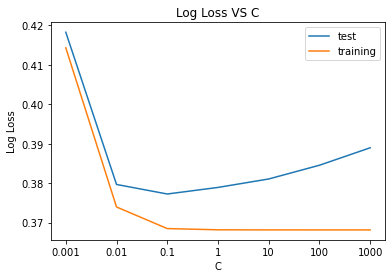

In [16]:
f1_C3 = pd.DataFrame(data={'test': pd.Series(inv_log_likelihood_test),'training': pd.Series(inv_log_likelihood_train), 'C':C})
f1_C3[['test', 'training']].plot()
plt.xlabel('C')
plt.xticks(ticks=np.arange(7), labels=C)
plt.ylabel('Log Loss')
plt.title('Log Loss VS C')

Text(0.5, 1.0, 'F1 Score VS C')

<Figure size 360x360 with 0 Axes>

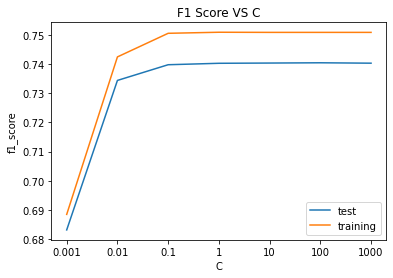

In [17]:
#27min
f1sTrain3 = []
f1sTest3 = []
for c in C:
    log = linear_model.LogisticRegression(random_state= 2021,max_iter = 1000, penalty='l1', solver='liblinear', C=c)
    log.fit(log_transform(x_train), y_train)
    y_pred = log.predict(log_transform(x_train))
    f1sTrain3.append(f1_score(y_train, y_pred))
    y_pred = log.predict(log_transform(x_test))
    f1sTest3.append(f1_score(y_test, y_pred))
plt.figure(figsize=(5,5))
f1_C2 = pd.DataFrame(data={'test': pd.Series(f1sTest3),'training': pd.Series(f1sTrain3)})   
f1_C2.plot()
plt.xlabel('C')
plt.xticks(ticks=np.arange(7), labels=C)
plt.ylabel('f1_score')
plt.title('F1 Score VS C')

#Best C - 0.1

## Final Result -Without Downsampling with Hyperparameter Tuned

In [5]:
#4m 54s
log=linear_model.LogisticRegression(random_state= 2021,max_iter = 1000, penalty='l1', solver='liblinear', C=0.1)
log.fit(log_transform(x_train), y_train)
predict_LOG = log.predict(log_transform(x_test))

report = """ 
Confusion_matrix:
{}
Accuracy: {}
Classification Report:
{}""".format(
metrics.confusion_matrix(y_test, predict_LOG),
metrics.accuracy_score(y_test, predict_LOG),
metrics.classification_report(y_test, predict_LOG))
print(report)

 
Confusion_matrix:
[[12985  1426]
 [ 2755  5944]]
Accuracy: 0.8190826482042406
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.90      0.86     14411
           1       0.81      0.68      0.74      8699

    accuracy                           0.82     23110
   macro avg       0.82      0.79      0.80     23110
weighted avg       0.82      0.82      0.82     23110



## Performance Measure

In [20]:
# 6m 6.7s
# prepare the cross-validation procedure
cv = KFold(n_splits=2, random_state=2021, shuffle=True)
# create model
model = linear_model.LogisticRegression(random_state= 2021,max_iter = 1000, penalty='l1', solver='liblinear', C=10)
# evaluate model
scores = cross_val_score(model, log_transform(x_train), y_train, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.822 (0.001)


### ROC

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.900


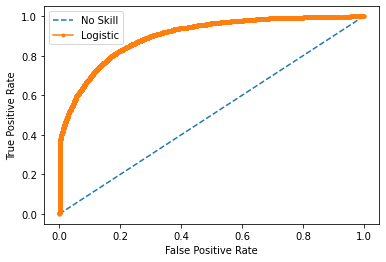

In [21]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
# fit a model
# predict probabilities
lr_probs = log.predict_proba(log_transform(x_test))
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

## Export

In [6]:
pickle.dump(log, open('3c.out.log', 'wb'))

## Feature Importance

In [5]:
log = pickle.load(open('3c.out.log', 'rb'))

In [6]:
categorical = ['ArrivalDateWeekNumber', 'Meal', 'Country', 'MarketSegment', 'DistributionChannel', 'ReservedRoomType', 'AssignedRoomType', 'DepositType', 'Agent', 'Company', 'CustomerType', 'Hotel']
numerical = ['LeadTime', 'StaysInWeekendNights', 'StaysInWeekNights', 'Adults', 'Children', 'Babies', 'IsRepeatedGuest', 'PreviousCancellations', 'PreviousBookingsNotCanceled', 'BookingChanges', 'DaysInWaitingList', 'ADR', 'TotalOfSpecialRequests']
colnames = enc.get_feature_names(categorical)
columnfeature = colnames.tolist() + numerical

In [7]:
pd.DataFrame(log_transform(x_test), columns=columnfeature)

,ArrivalDateWeekNumber_1,ArrivalDateWeekNumber_2,ArrivalDateWeekNumber_3,ArrivalDateWeekNumber_4,ArrivalDateWeekNumber_5,ArrivalDateWeekNumber_6,ArrivalDateWeekNumber_7,ArrivalDateWeekNumber_8,ArrivalDateWeekNumber_9,ArrivalDateWeekNumber_10,...,Adults,Children,Babies,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,BookingChanges,DaysInWaitingList,ADR,TotalOfSpecialRequests
0,-0.094198,-0.100209,-0.102927,-0.112437,-0.107602,-0.112388,-0.134438,-0.138713,-0.133266,-0.135146,...,0.285013,-0.262088,-0.086301,-0.170358,-0.101986,-0.085841,-0.341623,-0.133851,1.612440,-0.721487
1,-0.094198,-0.100209,-0.102927,-0.112437,-0.107602,-0.112388,-0.134438,-0.138713,-0.133266,-0.135146,...,0.285013,-0.262088,-0.086301,-0.170358,-0.101986,-0.085841,1.257680,-0.133851,2.194730,-0.721487
2,-0.094198,-0.100209,-0.102927,-0.112437,-0.107602,-0.112388,-0.134438,-0.138713,-0.133266,-0.135146,...,0.285013,-0.262088,-0.086301,-0.170358,-0.101986,-0.085841,-0.341623,-0.133851,0.042594,0.547182
3,-0.094198,-0.100209,-0.102927,-0.112437,-0.107602,-0.112388,-0.134438,-0.138713,-0.133266,-0.135146,...,-1.794183,-0.262088,-0.086301,-0.170358,1.030820,-0.085841,-0.341623,2.440745,0.133677,-0.721487
4,-0.094198,-0.100209,-0.102927,-0.112437,-0.107602,-0.112388,-0.134438,-0.138713,-0.133266,-0.135146,...,0.285013,-0.262088,-0.086301,-0.170358,-0.101986,-0.085841,-0.341623,-0.133851,1.569577,-0.721487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23105,-0.094198,-0.100209,-0.102927,-0.112437,-0.107602,-0.112388,-0.134438,-0.138713,-0.133266,-0.135146,...,0.285013,-0.262088,-0.086301,-0.170358,-0.101986,-0.085841,-0.341623,-0.133851,0.380138,-0.721487
23106,-0.094198,-0.100209,-0.102927,-0.112437,-0.107602,-0.112388,-0.134438,-0.138713,-0.133266,-0.135146,...,0.285013,-0.262088,-0.086301,-0.170358,-0.101986,-0.085841,-0.341623,-0.133851,-0.877882,-0.721487
23107,-0.094198,-0.100209,-0.102927,-0.112437,-0.107602,-0.112388,-0.134438,-0.138713,-0.133266,-0.135146,...,0.285013,-0.262088,-0.086301,-0.170358,-0.101986,-0.085841,-0.341623,-0.133851,0.776617,-0.721487
23108,-0.094198,-0.100209,-0.102927,-0.112437,-0.107602,-0.112388,-0.134438,-0.138713,-0.133266,-0.135146,...,0.285013,-0.262088,-0.086301,-0.170358,-0.101986,-0.085841,-0.341623,-0.133851,-0.895027,-0.721487


In [11]:
# top 10 important features for class 1 prediciton
feature_importance = pd.DataFrame(columnfeature, columns = ["feature"])
feature_importance["importance"] = log.coef_[0]
feature_importance = feature_importance.sort_values(by = ["importance"], ascending=False)
feature_importance

,feature,importance
918,PreviousCancellations,1.570557
263,DepositType_Non Refund,1.140669
189,Country_PRT,0.932690
573,Agent_9,0.698099
251,AssignedRoomType_A,0.694252
...,...,...
257,AssignedRoomType_G,-0.329375
262,DepositType_No Deposit,-0.353963
919,PreviousBookingsNotCanceled,-0.502691
242,ReservedRoomType_A,-0.632718


Text(0.5, 1.0, 'Feature Importance from Logistic Regression Model for Class 1 Prediction')

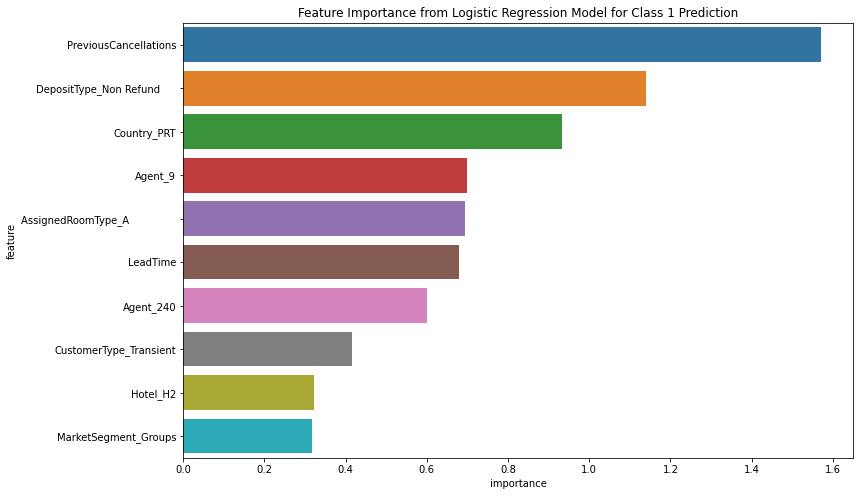

In [12]:
import seaborn as sns
plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance.head(10), y='feature', x='importance', orient='h')
plt.title('Feature Importance from Logistic Regression Model for Class 1 Prediction')

Text(0.5, 1.0, 'Feature Importance from Logistic Regression Model for Class 0 Prediction')

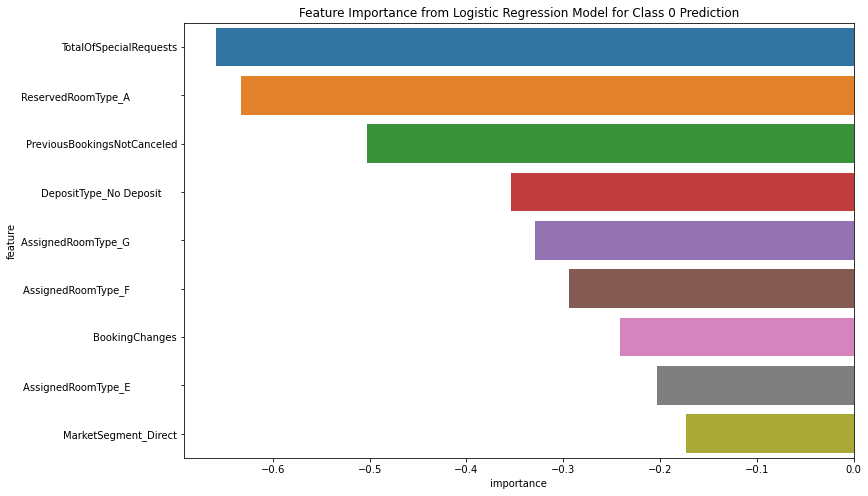

In [14]:
# top 10 important features for class 0 prediciton
import seaborn as sns
plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance.iloc[-1:-10:-1,:], y='feature', x='importance', orient='h')
plt.title('Feature Importance from Logistic Regression Model for Class 0 Prediction')